In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss


In [142]:
payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns='Unnamed: 0')
payout['ML_pct'] = payout['ML_pct']/100
payout

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,0.6364,-2.5,-4.0,NaN,NaN,0,57.15
1,1,155.0,0.3922,2.5,4.0,212.5,211.5,1,155.00
2,2,-165.0,0.6226,-3.5,-4.0,NaN,NaN,1,60.61
3,2,145.0,0.4082,3.5,4.0,212.5,211.0,0,145.00
4,3,-165.0,0.6226,-2.5,-4.0,NaN,NaN,0,60.61
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,0.3448,2.5,5.0,191.0,199.0,0,190.00
35970,17986,-120.0,0.5455,-3.0,-1.0,NaN,NaN,0,83.34
35971,17986,100.0,0.5000,3.0,1.0,214.5,212.0,1,100.00
35972,17987,-1400.0,0.9333,-12.5,-13.0,NaN,NaN,1,7.15


In [145]:
#payout.to_csv('../nss_capstone/payout.csv')

                        *******'ML_pct'***********

In [85]:
# The model!
# 20 folds

payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [89]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean()#.sort_values()

0.000   -1908.2125
0.001   -1487.1635
0.002   -1154.3830
0.003    -917.9185
0.004   -1017.8855
           ...    
0.096      -2.0000
0.097      -2.0000
0.098      -2.0000
0.099       3.0000
0.100       3.0000
Length: 101, dtype: float64

In [88]:
pd.DataFrame(profits,columns = np.linspace(start = 0, stop = .1, num = 101))

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,253.89,1274.89,-935.11,-2475.11,-2610.11,-2395.11,-2395.11,-2076.96,-1976.96,-3101.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2147.00,-1127.00,-722.00,-1097.00,-1837.00,-362.00,-762.00,-262.00,-262.00,-162.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1309.73,-909.73,-319.52,-14.52,380.48,-1274.52,-520.00,-40.00,-40.00,-540.00,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,0.0
3,874.71,871.00,1066.00,1366.00,-237.00,-997.00,-1067.00,-667.00,-997.00,-897.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3957.16,2357.16,3287.16,4198.38,4727.04,4412.04,2277.00,2377.00,2677.00,1412.00,...,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0
5,-1402.20,-1762.20,-1562.20,-342.20,562.80,1246.80,1466.76,1386.76,1586.76,1086.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-2150.23,-1789.99,-1580.99,-761.00,-611.00,-611.00,-111.00,-1111.00,-1071.00,-771.00,...,124.0,124.0,124.0,124.0,124.0,0.0,0.0,0.0,0.0,0.0
7,-9569.63,-7787.93,-6307.93,-6568.00,-6385.00,-5840.00,-5740.00,-5155.00,-4555.00,-4555.00,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
8,-5634.83,-4534.83,-4179.92,-4079.92,-3839.92,-4254.92,-3254.92,-3524.92,-4299.92,-3099.92,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
9,-1065.77,-610.77,-3250.77,-2735.77,-3197.77,-2597.77,-2197.77,-2097.77,-1897.77,-1897.77,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


In [45]:
predicted_probabilities

array([0.55352822, 0.44916292, 0.74155721, ..., 0.46711658, 0.53964679,
       0.45938154])

In [46]:
X_test

array([[0.6078],
       [0.4255],
       [0.7368],
       ...,
       [0.4878],
       [0.5455],
       [0.5   ]])

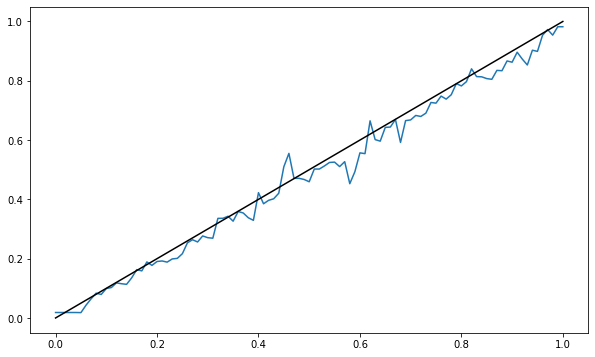

In [54]:
# 30 fold

plt.figure(figsize = (10,6))

calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
plt.plot(
np.linspace(start = 0, stop = 1, num = 101),
calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1])


calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
plt.plot(
np.linspace(start = 0, stop = 1, num = 101),
np.linspace(start = 0, stop = 1, num = 101), color = 'black')



In [67]:
predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

percentage_differences = predicted_probabilities - closing_moneyline_odds    
selected_bets = percentage_differences >= threshold

payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
results = y_test.reset_index(drop = True) 

bets_won = selected_bets * results * payouts
bets_lost = selected_bets * (1-results) * -wager
profit = bets_won.sum() + bets_lost.sum()
# wager = 100  # Set the wager amount to $100
# profit = np.sum(selected_bets * (wager * closing_moneyline_odds - wager))
# profits.append(profit)

# replaced_wagers.append(np.sum(selected_bets))
# bets_won.append(np.sum(selected_bets * y_test))  # Sum of bets won (replaced wagers)
# bets_lost.append(np.sum(selected_bets * (1 - y_test))) 

In [69]:
profit

1750.2099999999991

In [160]:
selected_bets.sum()*100

300

In [61]:
y_test.reset_index(drop = True) * payouts

0        64.52
1         0.00
2        35.72
3         0.00
4         0.00
         ...  
7189      0.00
7190      0.00
7191    105.00
7192      0.00
7193    100.00
Length: 7194, dtype: float64

In [90]:
payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 30
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [108]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,-2613.90,-2757.90,-1992.90,-2362.90,-2004.75,-1604.75,-1604.75,-1484.75,-1184.75,-1184.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2466.15,-2348.00,-1493.00,-993.00,-793.00,-793.00,-1293.00,-1193.00,-2093.00,-1983.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3650.71,2437.00,2437.00,2537.00,2637.00,1757.00,2032.00,1117.00,717.00,717.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3191.99,-2249.05,-2702.05,-2052.05,-1252.05,-1252.05,-1397.05,-1297.05,-1414.05,-1414.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1884.55,2209.55,2769.55,2894.55,2614.55,2614.55,3054.55,3159.55,3559.55,3559.55,...,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0,737.0
5,-3022.96,-2292.96,-1872.96,-1342.96,-802.96,-602.96,-602.96,-102.96,-242.96,-242.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-2085.00,-1570.96,-685.96,-1635.96,-1435.96,-1335.96,-1035.96,479.04,-257.96,-257.96,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
7,-4374.21,-4225.96,-4125.96,-3630.96,-3630.96,-3310.96,-2390.96,-2290.96,-2290.96,-1630.96,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
8,1736.08,1836.08,2166.08,2691.08,1951.08,1951.08,1176.08,1196.08,1296.08,1196.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-2499.70,-1665.96,-2865.96,-2465.96,-2154.15,-2804.15,-2786.00,-2786.00,-2786.00,-3186.00,...,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0


                        ***********ML_pct, Open/Close Spread, Open/Close Total***********

In [150]:
#payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [152]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()

0.004   -272.0315
0.008   -186.3710
0.003   -148.8240
0.000   -143.5725
0.002   -132.8950
           ...   
0.022    508.6215
0.023    513.6215
0.019    527.4625
0.021    546.6625
0.020    584.1125
Length: 101, dtype: float64

In [153]:
profit

-123.07

In [157]:
selected_bets.sum() * 100

300

In [116]:
# df = pd.read_csv('../nss_capstone/df_rebuild.csv')

# variables = ['ML_pct',
#             'Close Total',
#              'Close Spread']

# X = df[variables]
# y = df['W/L_bool']

# grouped = df.groupby('game_id')
# train_indices, test_indices = [], []
# for _, group_indices in grouped.groups.items():
#     group_train_indices, group_test_indices = train_test_split(group_indices, test_size=0.2, random_state=321)
#     train_indices.extend(group_train_indices)
#     test_indices.extend(group_test_indices)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# imputer = SimpleImputer(strategy='mean')

# imputer.fit(X_train)

# X_train_imputed = imputer.transform(X_train)
# X_test_imputed = imputer.transform(X_test)

# base_classifier = GradientBoostingClassifier()

# calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5) # isotonic/ cv?

# calibrated_classifier.fit(X_train_imputed, y_train)

# probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [66]:
# df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [67]:
# df_prob

,Class 0 Probability,Class 1 Probability
0,0.585905,0.414095
1,0.739234,0.260766
2,0.772590,0.227410
3,0.119895,0.880105
4,0.868366,0.131634
...,...,...
7190,0.650899,0.349101
7191,0.682882,0.317118
7192,0.586431,0.413569
7193,0.804924,0.195076


In [109]:
payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns = 'Unnamed: 0').fillna('')
payout['ML_pct'] = pd.to_numeric(payout['ML_pct'], errors='coerce')
payout['ML_pct'] = payout['ML_pct'] /100

In [110]:
payout

,game_id,ML,ML_pct,W/L_bool,Payout
0,1,-175.0,0.006364,0,57.15
1,1,155.0,0.003922,1,155.0
2,2,-165.0,0.006226,1,60.61
3,2,145.0,0.004082,0,145.0
4,3,-165.0,0.006226,0,60.61
...,...,...,...,...,...
35969,17985,190.0,0.003448,0,190.0
35970,17986,-120.0,0.005455,0,83.34
35971,17986,100.0,0.005000,1,100.0
35972,17987,-1400.0,0.009333,1,7.15


In [194]:
#payout.to_csv('../nss_capstone/payout.csv')

In [111]:
df_rebuild_wager = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [113]:
df_rebuild_wager[['Open Spread', 'Close Spread', 'Open Total', 'Close Total']]

,Open Spread,Close Spread,Open Total,Close Total
0,-2.5,-4.0,,
1,2.5,4.0,212.5,211.5
2,-3.5,-4.0,,
3,3.5,4.0,212.5,211.0
4,-2.5,-4.0,,
...,...,...,...,...
35969,2.5,5.0,191.0,199.0
35970,-3.0,-1.0,,
35971,3.0,1.0,214.5,212.0
35972,-12.5,-13.0,,


In [114]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML','ML_pct','Open Spread', 'Close Spread', 'Open Total', 'Close Total','W/L_bool']]

In [115]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool
0,1,-175.0,63.64,-2.5,-4.0,,,0
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1
2,2,-165.0,62.26,-3.5,-4.0,,,1
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0
4,3,-165.0,62.26,-2.5,-4.0,,,0
...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0
35970,17986,-120.0,54.55,-3.0,-1.0,,,0
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1


In [116]:
df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')

# Calculate the 'Payout' column
df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)
df_rebuild_wager.loc[df_rebuild_wager.groupby('game_id').cumcount() > 0, 'Payout'] = np.nan

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')
C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)


In [117]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.142857
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,NaN
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.606061
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,NaN
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.606061
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,NaN
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.333333
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,NaN
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.142857


In [118]:
# Replace NaN values in the second row with corresponding payout values
second_row_mask = df_rebuild_wager.groupby('game_id').cumcount() == 1
df_rebuild_wager.loc[second_row_mask, 'Payout'] = df_rebuild_wager.loc[second_row_mask, 'ML'].abs()

In [119]:
df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\561021500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)


In [120]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.15
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,155.00
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.61
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,145.00
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.61
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,190.00
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.34
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,100.00
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.15


In [121]:
payout = df_rebuild_wager 

In [122]:
#payout.to_csv('../nss_capstone/payout.csv')

In [123]:
df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1

# Set multi-index by 'Game' and the row number within each game
df_rebuild_wager.set_index(['Game', df_rebuild_wager.groupby('Game').cumcount()], inplace=True)

# Unstack the DataFrame
pivoted_df = df_rebuild_wager.unstack()

# Flatten the column index
pivoted_df.columns = [f'{col}_{num}' for col, num in pivoted_df.columns]

df_rebuild_wager = pd.DataFrame(pivoted_df)

df_rebuild_wager

C:\Users\tjsim\AppData\Local\Temp\ipykernel_46428\4286494612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1


,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1
Game,,,,,,,,,,
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...
17983,17983,17983,-125.0,105.0,55.56,48.78,0,1,80.00,105.0
17984,17984,17984,-305.0,255.0,75.31,28.17,1,0,32.79,255.0
17985,17985,17985,-230.0,190.0,69.7,34.48,1,0,43.48,190.0


In [124]:
df_rebuild_wager = pd.merge(df_rebuild_wager, df_prob, how='inner', left_index=True, right_index=True)

In [125]:
df_rebuild_wager

,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1,Class 0 Probability,Class 1 Probability
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0,0.739234,0.260766
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.772590,0.227410
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0,0.119895,0.880105
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0,0.868366,0.131634
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0,0.585948,0.414052
...,...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,7190,-340.0,280.0,77.27,26.32,0,1,29.42,280.0,0.650899,0.349101
7191,7191,7191,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.682882,0.317118
7192,7192,7192,-1750.0,950.0,94.59,9.52,1,0,5.72,950.0,0.586431,0.413569
7193,7193,7193,-290.0,230.0,74.36,30.3,1,0,34.49,230.0,0.804924,0.195076


In [126]:
df_rebuild_wager = df_rebuild_wager.rename(columns = {'game_id_1': 'game_id', 'ML_0': 'ML_fav',
                       'ML_1': 'ML_dog', 'ML_pct_0':'ML_fav_pct',
                       'ML_pct_1': 'ML_dog_pct','Class 0 Probability': 'Predict_dog',
                        'Class 1 Probability': 'Predict_fav','Payout_0': 'Payout_fav',
                       'Payout_1': 'Payout_dog', 'W/L_bool_0': 'W/L_fav',
                       'W/L_bool_1':'W/L_dog'})

In [128]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML_fav','ML_dog','ML_fav_pct','ML_dog_pct', 'Predict_fav','Predict_dog',
          'W/L_fav','W/L_dog','Payout_fav','Payout_dog']]

In [129]:
df_rebuild_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
2,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
3,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
4,4,-155.0,135.0,60.78,42.55,0.131634,0.868366,1,0,64.52,135.0
5,5,-200.0,175.0,66.67,36.36,0.414052,0.585948,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,-340.0,280.0,77.27,26.32,0.349101,0.650899,0,1,29.42,280.0
7191,7191,-165.0,145.0,62.26,40.82,0.317118,0.682882,1,0,60.61,145.0
7192,7192,-1750.0,950.0,94.59,9.52,0.413569,0.586431,1,0,5.72,950.0
7193,7193,-290.0,230.0,74.36,30.3,0.195076,0.804924,1,0,34.49,230.0


In [130]:
df_rebuild_wager.to_csv('../nss_capstone/df_rebuild_wager.csv')

In [153]:
df = pd.read_csv('../nss_capstone/df_rebuild_wager.csv').drop(columns = 'Unnamed: 0')
df.head(3)

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
0,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
1,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
2,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
